##### Final Project: Classification of an Observed Data Set

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams['savefig.dpi'] = 90
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from scipy.stats import norm
import numpy as np
from sklearn.mixture import GaussianMixture
from astroML.plotting.tools import draw_ellipse

np.random.seed(0)

lums, size = np.loadtxt('galaxies.dat', usecols = (0, 1), unpack = True)
X = np.vstack([size, lums]).T

def CompareMultipleRoutines(X, predictions, checkMultipleDisputes):
    predictions = np.array(predictions) #casting to an array, for cleanliness of code
    X = np.array(X)
    N = len(predictions)
    Disputes = []
    numDisputes = np.zeros(len(X))
    for n in range(1, N/2 + 1):
        disputed_list = []
        for i in range(len(X)):
            if np.count_nonzero(predictions[:, i]) == n or np.count_nonzero(predictions[:, i]) == (N-n):
                disputed_list.append(X[i])
                numDisputes[i] += 1
        Disputes.append(np.array(disputed_list))
    if checkMultipleDisputes == True:
        disputedByMultiple = []
        for i in range(len(X)):
            if numDisputes[i] >= 2:
                disputedByMultiple.append(X[i])
        Disputes.append(np.array(disputedByMultiple))
    return np.array(Disputes)

def CompareManyRoutinesToOne(X, routine1, routines, checkMultipleDisputes):
    routine1 = np.array(routine1) #casting to an array, for cleanliness of code
    routines = np.array(routines)
    N = len(routines)
    Disputes = []
    numDisputes = np.zeros(len(X))
    for n in range(0, N):
        disputed_list = []
        for i in range(len(X)):
            if routine1[i] != routines[n, i]:
                disputed_list.append(X[i])
                numDisputes[i] += 1
        Disputes.append(np.array(disputed_list))
    if checkMultipleDisputes == True:
        disputedByMultiple = []
        for i in range(len(X)):
            if numDisputes[i] >= 2:
                disputedByMultiple.append(X[i])
        Disputes.append(np.array(disputedByMultiple))
    return np.array(Disputes)

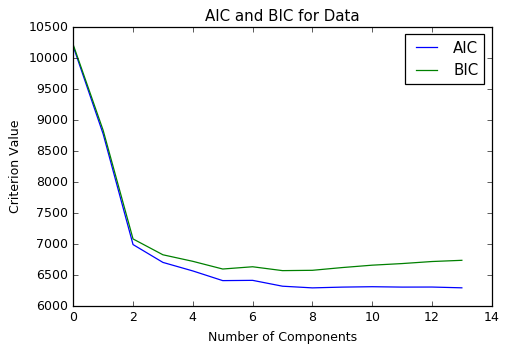

best fit converged: True
number of interations = 7
BIC: N components = 8


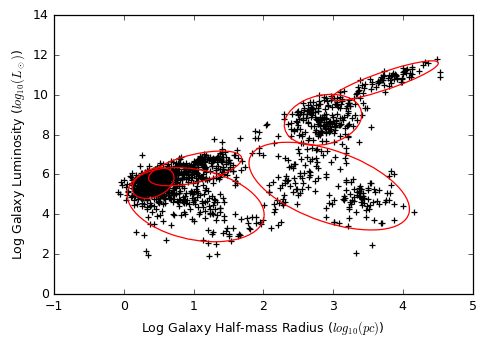

In [13]:
#Gaussian Mixture Modeling
N = np.arange(1, 15)
models = [None for n in N]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i], covariance_type='full').fit(X)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

plt.plot(AIC, label = 'AIC')
plt.plot(BIC, label = 'BIC')
plt.xlabel('Number of Components')
plt.ylabel('Criterion Value')
plt.title('AIC and BIC for Data')
plt.legend(loc = 0)
plt.show()
i_best = np.argmin(BIC)
gmm_best = models[5]
print 'best fit converged:', gmm_best.converged_
print 'number of interations =', gmm_best.n_iter_
print 'BIC: N components = %i' % N[i_best]

plt.scatter(X[:,0], X[:,1], color = 'k', marker = '+')
plt.xlabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
plt.ylabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')

for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[2], fc='none', ec='r')
    
plt.show()

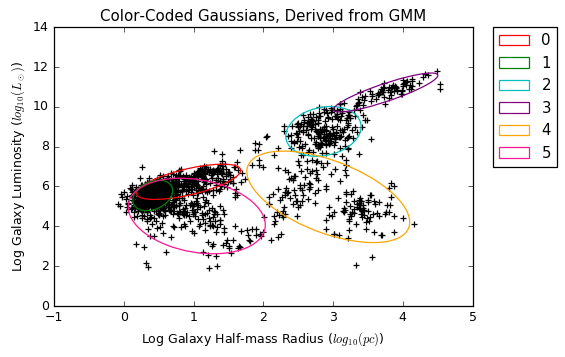

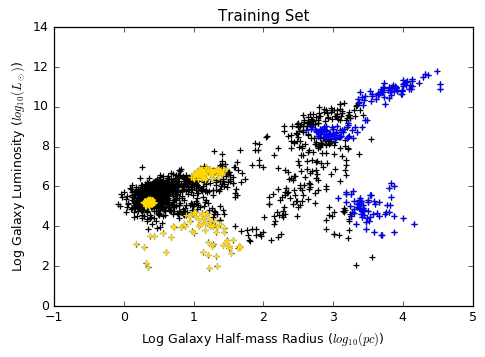

In [11]:
#Color-code the gaussians, so that it is easier to see and classify them
colors = ['r', 'g', 'c', 'purple', 'orange', 'deeppink']
labels = range(0, 8)

plt.scatter(X[:,0], X[:,1], color = 'k', marker = '+')
plt.xlabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
plt.ylabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')

for mu, C, w, c, l in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_, colors, labels):
    draw_ellipse(mu, C, scales=[2], fc='none', ec=c, label = l)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Color-Coded Gaussians, Derived from GMM')
plt.xlabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
plt.ylabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')
plt.show()

#Search for which gaussians are part of which group and split them
peaks = []
new_groupings = []
group_0_indices = []
group_1_indices = []
counter = 0
probs = gmm_best.predict_proba(X)

for i in range(6):
    indexMax = np.argmax(probs[:, i]) #Search for the peaks of each Gaussian
    peaks.append(X[indexMax])
    if X[indexMax, 0] >= 2.: #By inspection, roughly the dividing line between the two main groups I want to create
        new_groupings.append(1)
        group_1_indices.append(counter)
    else:
        new_groupings.append(0)
        group_0_indices.append(counter)
    counter += 1


#Create the training set
x_training = []
y = []

for i in range(6): #For every Gaussian, we select the points with the greatest probabilities - i.e., nearest the peaks. 
    indices = np.argpartition(probs[:, i], int(-.25/6 * len(X)))[int(-.25/6 * len(X)):] #Choosing the top 25% of each, 
                                                                                        #such that we end up with a 
                                                                                        #training set about 25% of the 
                                                                                        #size of the original data set.
    if i in group_1_indices:
        x_training.append(X[indices])
        y.append(np.ones(len(indices)))
    else:
        x_training.append(X[indices])
        y.append(np.zeros(len(indices)))

y = np.array(y).flatten()

x_training = np.reshape(x_training, (len(y), 2))

colors2 = ListedColormap(['gold', 'b'])
plt.scatter(X[:,0], X[:,1], c = 'k', marker = '+')
plt.scatter(x_training[:, 0], x_training[:, 1], c=y, cmap=colors2, marker = '+')
plt.title('Training Set')
plt.xlabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
plt.ylabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')
plt.show()

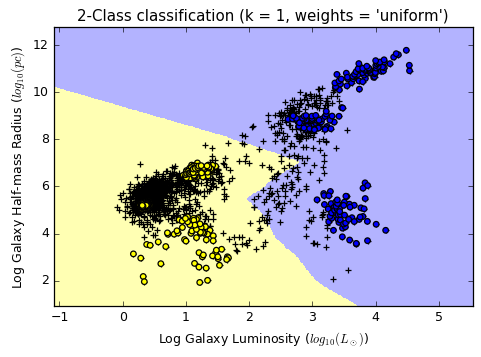

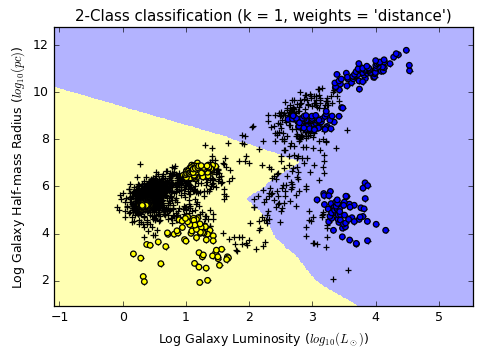

No difference between the classification routines.


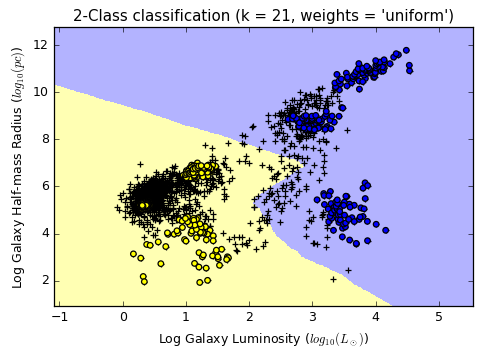

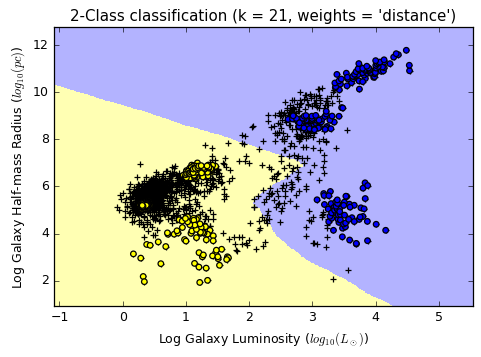

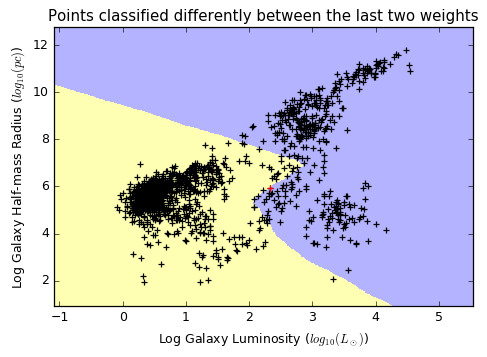

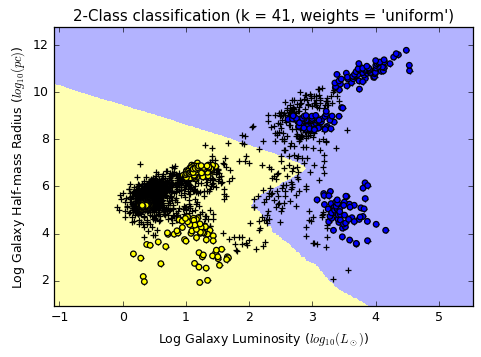

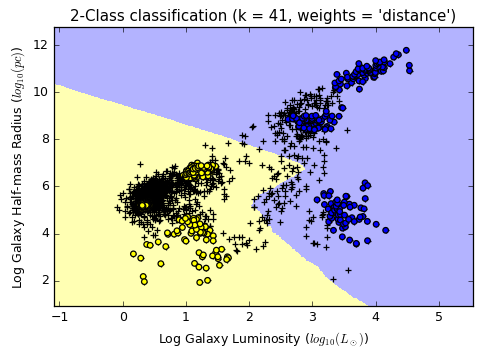

No difference between the classification routines.


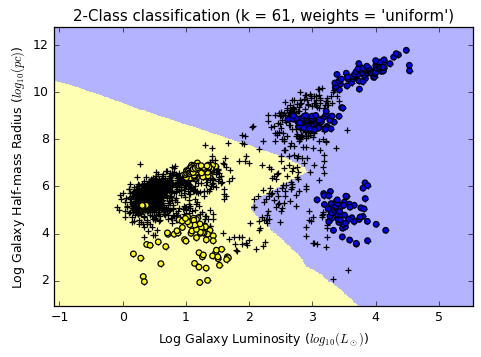

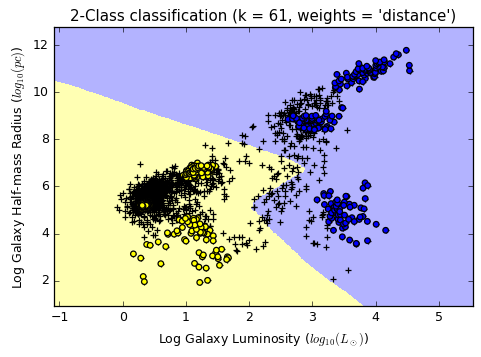

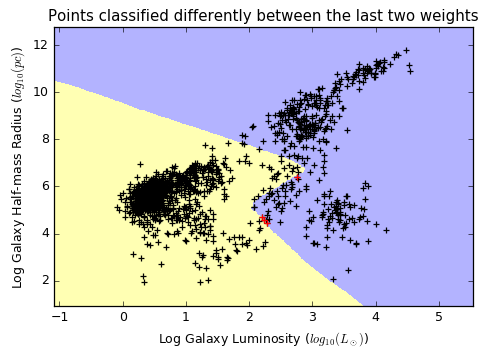

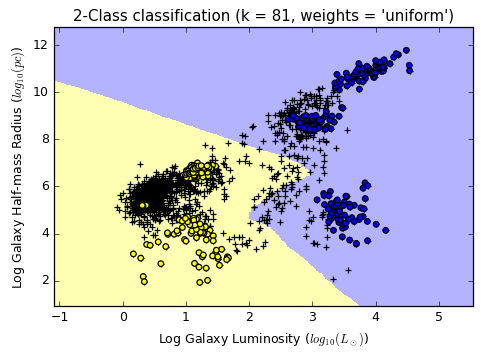

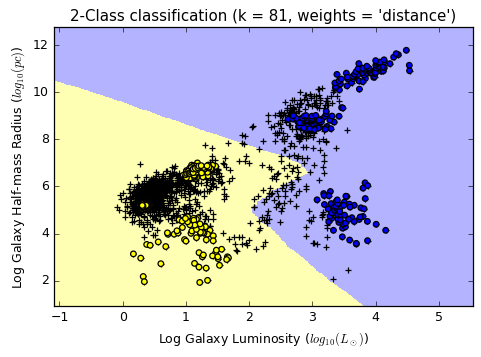

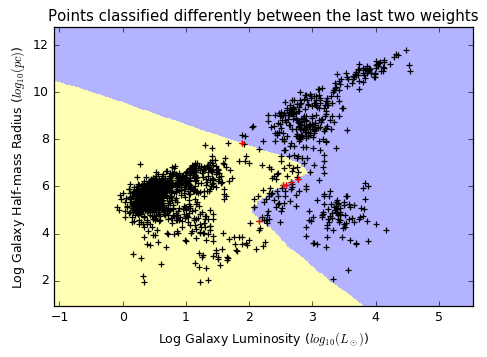

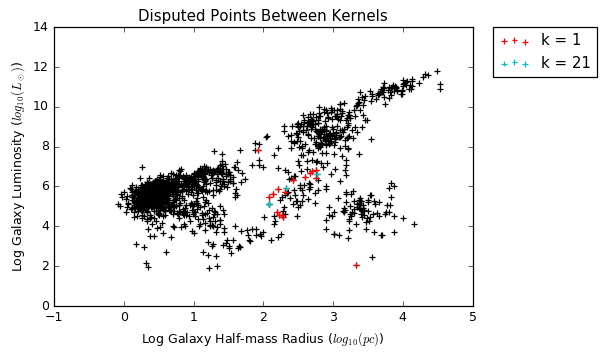

In [14]:
#Nearest Neighbors
N_neighbors = np.arange(1, 82, 20)

h = .02

cmap_light = ListedColormap(['#FFFFB3', '#B3B3FF'])
cmap_bold = ListedColormap(['#FFFF00', '#0000FF'])

NN_Distance_Predictions = []
for n_neighbors in N_neighbors:
    NN_predictions = []
    differences = []
    for weights in ['uniform', 'distance']:
        # we create an instance of Neighbours Classifier and fit the data.
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        clf.fit(x_training, y)

        # Plot the decision boundary.
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure()
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

        # Plot also the training points
        plt.scatter(X[:,0], X[:,1], c = 'k', marker = '+')
        plt.scatter(x_training[:, 0], x_training[:, 1], c=y, cmap=cmap_bold)
    
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title("2-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))
        plt.ylabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
        plt.xlabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')
        plt.show()
        NN_predictions.append(clf.predict(X))
        
        if n_neighbors == 21 and weights == 'distance': #Saving a NN classification for future comparisons
            NN_Prediction = clf.predict(X)
            NN_Prediction_DecisionBoundary = np.array([xx, yy, Z])
        if weights == 'distance':
            NN_Distance_Predictions.append(clf.predict(X))
            
    for i in range(len(X)): #Scanning through all the points
        if NN_predictions[0][i] != NN_predictions[1][i]:
            differences.append(X[i])
    differences = np.array(differences)
    
    if len(differences) == 0:
        print 'No difference between the classification routines.'
    else:
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.scatter(X[:, 0], X[:, 1], c = 'k', marker = '+')
        plt.scatter(differences[:, 0], differences[:, 1], marker = '+', color = 'r')
        plt.title('Points classified differently between the last two weights')
        plt.ylabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
        plt.xlabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')
        plt.show()
        

NN_Differences = CompareMultipleRoutines(X, NN_Distance_Predictions, False)

#Plotting disputations between number of neighbors
plt.scatter(X[:, 0], X[:, 1], c = 'k', marker = '+')
for differences, color, label in zip(NN_Differences, ['r', 'c', 'b', 'g', 'gold'], N_neighbors):
    if len(differences) != 0:
        plt.scatter(differences[:, 0], differences[:, 1], color = color, label = 'k = {}'.format(label),
                   marker = '+')
    
plt.title('Disputed Points Between Kernels')
plt.xlabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
plt.ylabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

For Nearest Neighbors, there did not seem to be much of a difference at each k between weighting points by distance, versus uniform weights (save some slightly smoother boundary curves). What did happen, however, was a massive increase in runtime as k increased, along with an increase in number of differing points between uniform and distance weights, and a decrease in differing points between successive runs for the distance weights. The optimum seems to be somewhere around 21 neighbors.

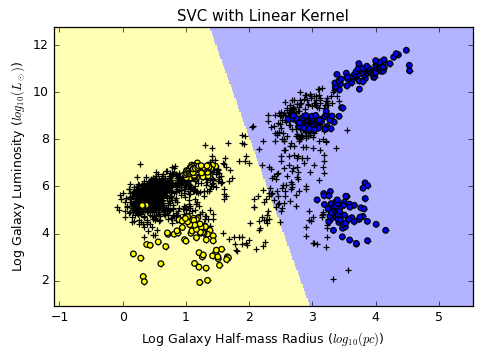

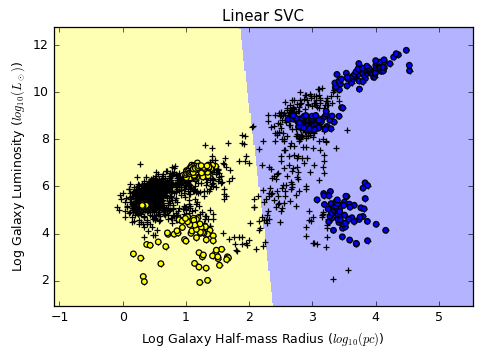

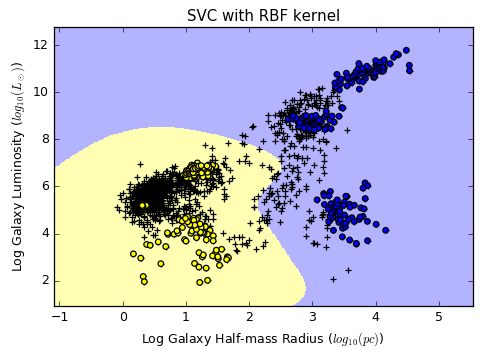

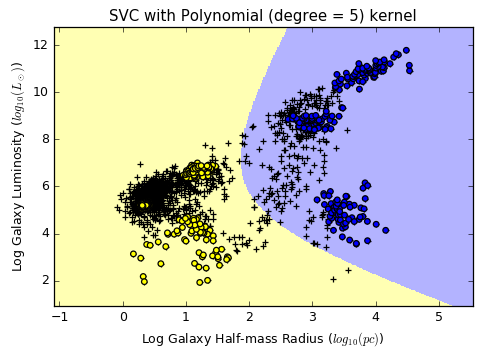

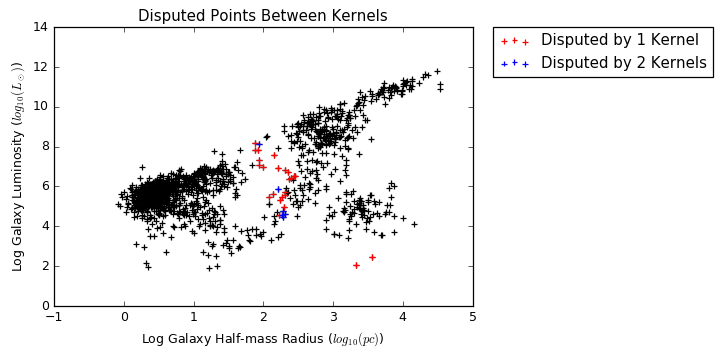

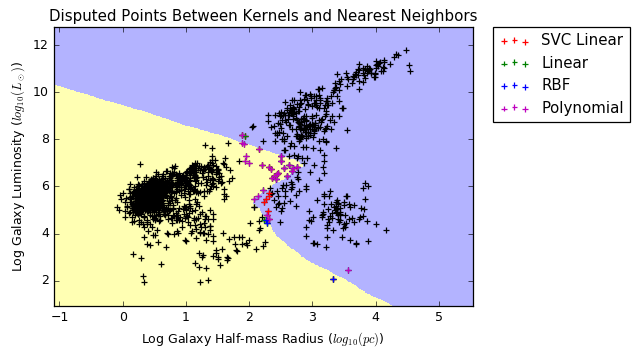

In [7]:
#Support Vector Machines
svc = svm.SVC(kernel = 'linear').fit(x_training, y)

svc_rbf = svm.SVC(kernel = 'rbf', gamma = 0.5).fit(x_training, y)

svc_poly = svm.SVC(kernel = 'poly', degree = 5).fit(x_training, y)

lin_svc = svm.LinearSVC().fit(x_training, y)

Titles = ['SVC with Linear Kernel', 'Linear SVC', 'SVC with RBF kernel', 'SVC with Polynomial (degree = 5) kernel']

SVMpredictions = []
for predictor, title in zip([svc, lin_svc, svc_rbf, svc_poly], Titles):
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = predictor.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    if predictor == svc_rbf:
        SVC_RBF_Decision_Boundary = np.array([xx, yy, Z]) #Saving the decision boundary for later comparison
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.scatter(X[:,0], X[:,1], c = 'k', marker = '+')
    plt.scatter(x_training[:, 0], x_training[:, 1], c=y, cmap=cmap_bold)
    plt.title(title)
    plt.xlabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
    plt.ylabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')
    plt.show()
    
    SVMpredictions.append(predictor.predict(X))

#Find disputed points between the routines
disputedBy1, disputedBy2 = CompareMultipleRoutines(X, SVMpredictions, False)

SVC_Linear_vs_NN, Linear_vs_NN, RBF_vs_NN, Poly_vs_NN = \
                    CompareManyRoutinesToOne(X, NN_Prediction, SVMpredictions, False)

#Plotting disputations between kernels
plt.scatter(X[:, 0], X[:, 1], c = 'k', marker = '+')
if len(disputedBy1) != 0:
    plt.scatter(disputedBy1[:, 0], disputedBy1[:, 1], c = 'r', marker = '+', label = 'Disputed by 1 Kernel')
if len(disputedBy2) != 0:
    plt.scatter(disputedBy2[:, 0], disputedBy2[:, 1], c = 'b', marker = '+', label = 'Disputed by 2 Kernels')
    
plt.title('Disputed Points Between Kernels')
plt.xlabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
plt.ylabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#Plotting disputations between kernels and Nearest Neighbors
plt.pcolormesh(NN_Prediction_DecisionBoundary[0], NN_Prediction_DecisionBoundary[1], 
              NN_Prediction_DecisionBoundary[2], cmap = cmap_light)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.scatter(X[:, 0], X[:, 1], c = 'k', marker = '+')
for compare, color, labels in zip([SVC_Linear_vs_NN, Linear_vs_NN, RBF_vs_NN, Poly_vs_NN], 
                                  ['r', 'g', 'b', 'm'],
                                 ['SVC Linear', 'Linear', 'RBF', 'Polynomial']):
    if len(compare) != 0:
        plt.scatter(compare[:, 0], compare[:, 1], c = color, marker = '+', label = labels)
        
plt.title('Disputed Points Between Kernels and Nearest Neighbors')
plt.xlabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
plt.ylabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()




SVC_RBF_Predictions = SVMpredictions[2] #Saving what appears to be the best categorization routine for later comparisons

For SVM, changing the kernel of the method created drastic differences. Interestingly, while both Linear SVC and the SVC with a linear kernel both created linear boundaries between the regions, the slopes were quite different. The RBF kernel, however, seemed to most mimic the results of Nearest Neighbors, with a sort of curve directly between the regions. As gamma increases, though, the curve gets tighter and tighter to the yellow training set. (Although, the RBF curve did diverge from Nearest Neighbors as radius increased and luminosity decreased, with the boundary line curving back to hug the yellow training set.)
Likewise, the polynomial seemed to enclose the blue training set, growing steeper as the degree increased (as one would expect). It also did diverge from Nearest Neighbors, hugging the blue training set for both high and low luminosity.

In the last plot, we can see exactly where the classifications diverged. Here all the data points are overplotted with the Nearest Neighbors classification scheme (with n_neighbors = 21, weights = 'distance'). As we can see, the biggest discrepancy is in the upper-most pocket, where Nearest Neighbors classified the stars are part of group 0, while multiple SVM kernels classified the points as part of group 1. (Which groups did exactly what can be seen by close examination of the respective plots, or by commenting out parts of the code to hide displaying discrepancies between certain groups.)

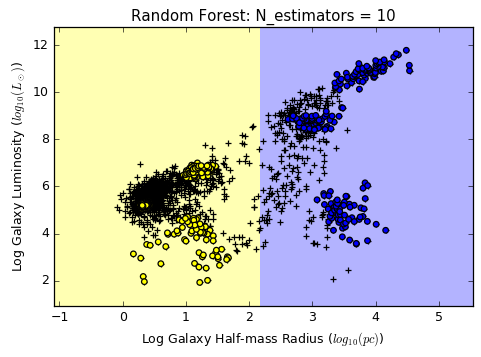

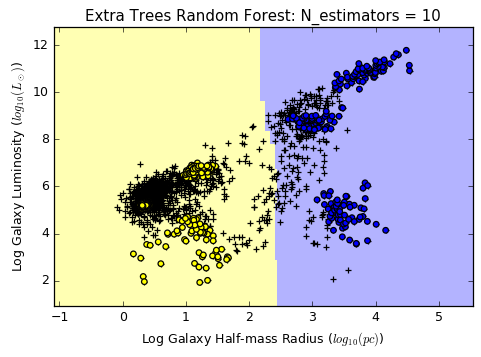

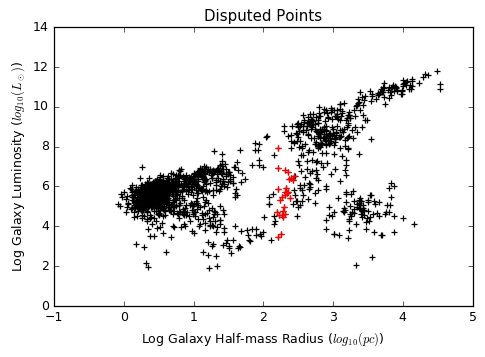

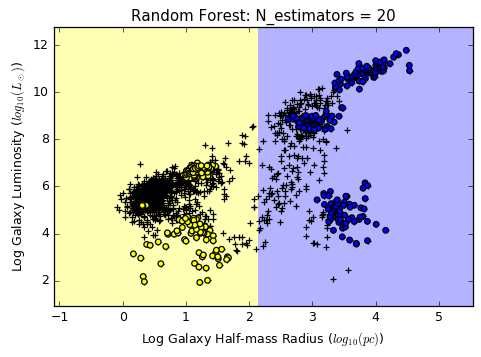

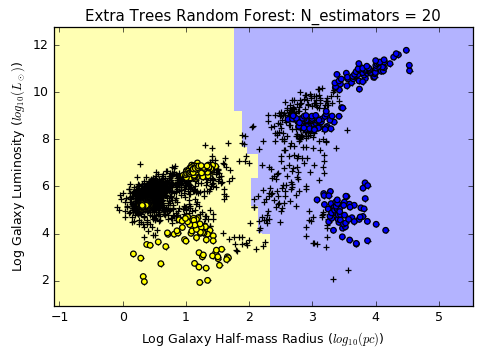

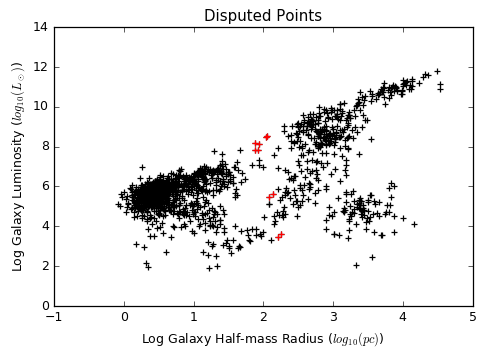

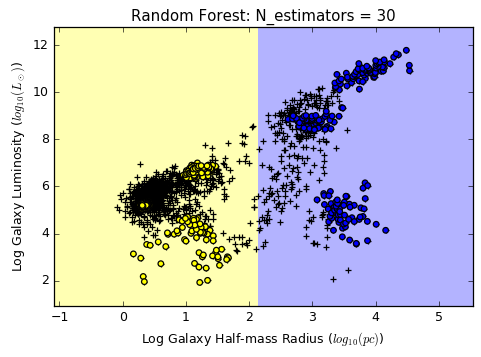

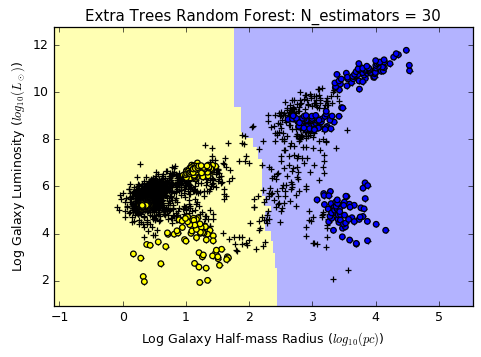

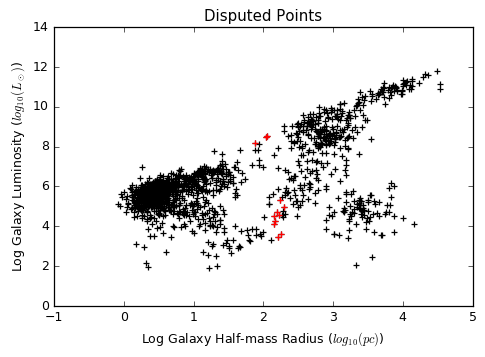

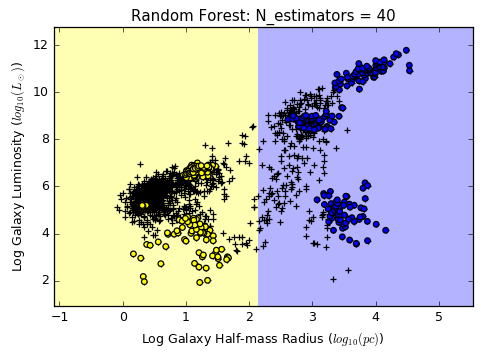

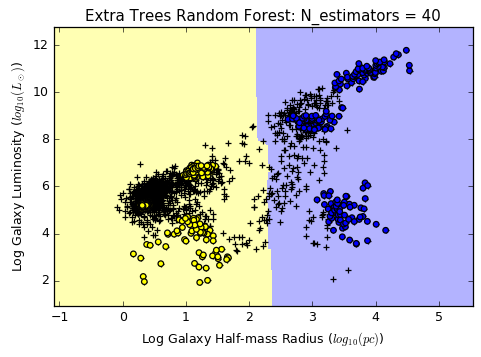

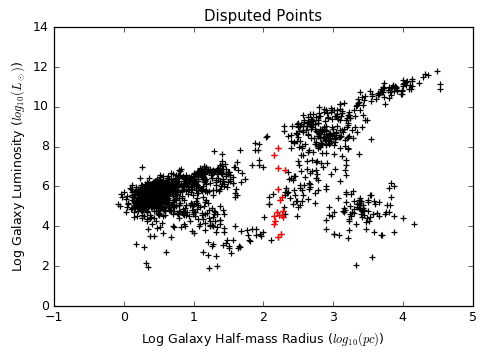

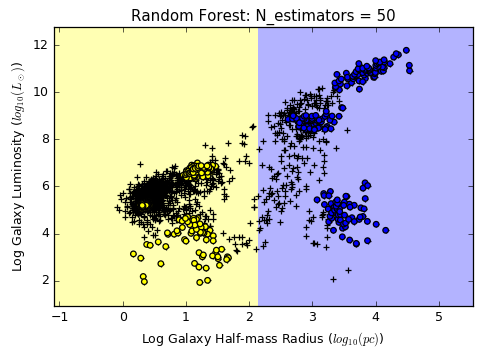

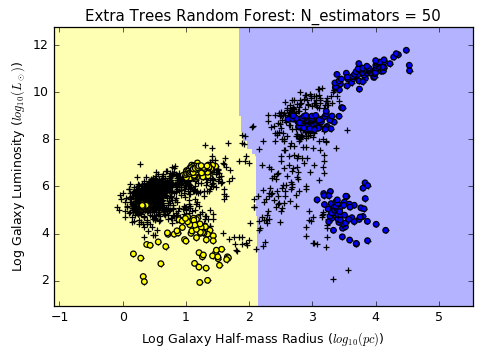

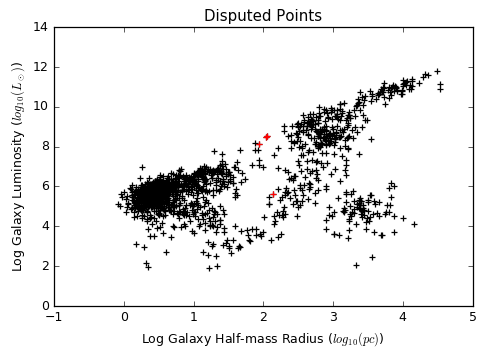

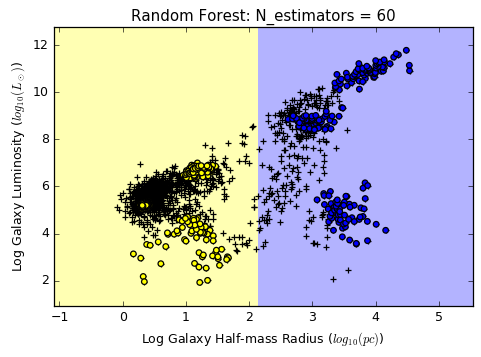

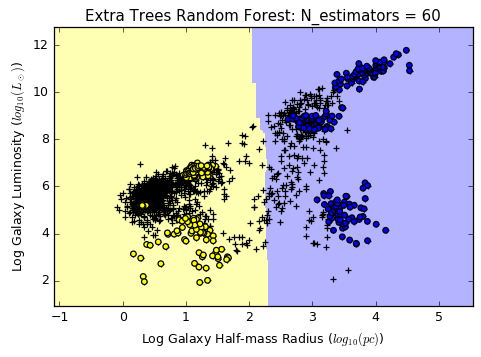

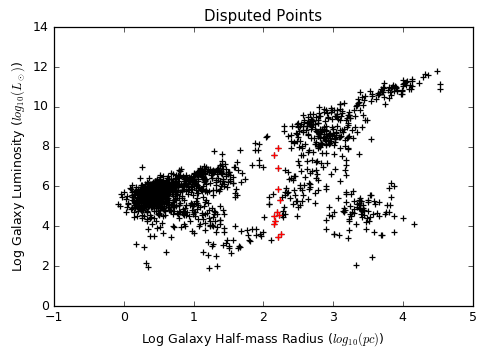

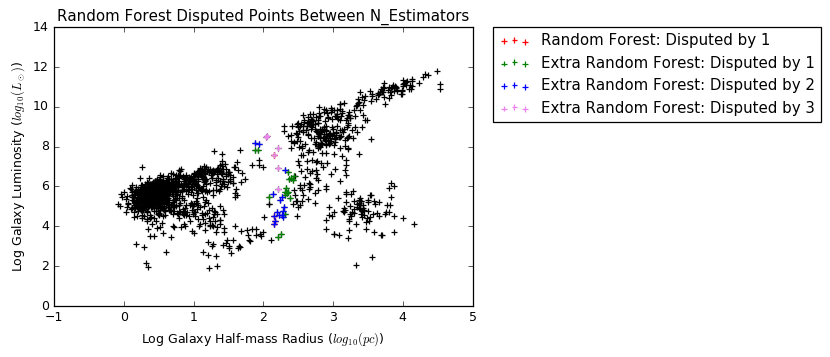

In [8]:
#Random Forest
N_Estimators = np.arange(10, 70, 10)

RandForestPredictions = [] #List of predictions by Random Forest for each N_Estimators (will have length 6)
ExtraRandForestPredictions = [] #List of predicitions by Extra Random Forest for each N_Estimators (will have length 6)

for n in N_Estimators:
    clf2 = RandomForestClassifier(n_estimators = n, max_features = np.sqrt(len(X[0])))
    clf3 = ExtraTreesClassifier(n_estimators = n, max_features = np.sqrt(len(X[0])))
    clf2.fit(x_training, y)
    clf3.fit(x_training, y)
    
    RandForest = clf2.predict(X)
    ExtraRandForest = clf3.predict(X)
    
    RandForestPredictions.append(RandForest)
    ExtraRandForestPredictions.append(ExtraRandForest)
    
    for forest, title in zip([clf2, clf3], ['Random Forest', 'Extra Trees Random Forest']):
    
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
        Z = forest.predict(np.c_[xx.ravel(), yy.ravel()])
        
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        
        plt.scatter(X[:,0], X[:,1], c = 'k', marker = '+')
        plt.scatter(x_training[:, 0], x_training[:, 1], c=y, cmap=cmap_bold)
        plt.title(title + ': N_estimators = {}'.format(n))


        plt.xlabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
        plt.ylabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')
        plt.show()
    
    differences = []
    
    for i in range(len(X)):
        if RandForest[i] != ExtraRandForest[i]:
            differences.append(X[i])
    differences = np.array(differences)
    
    if len(differences) == 0:
        print 'No classification discrepancies between these methods.'
    else:
        plt.scatter(X[:,0], X[:,1], c = 'k', marker = '+')
        plt.scatter(differences[:, 0], differences[:, 1], c = 'r', marker = '+')
        plt.title('Disputed Points')
        plt.xlabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
        plt.ylabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')
        plt.show()

Rand_disputed_by_1, Rand_disputed_by_2, Rand_disputed_by_3 = CompareMultipleRoutines(X, RandForestPredictions, False)
Extra_disputed_by_1, Extra_disputed_by_2, Extra_disputed_by_3 = CompareMultipleRoutines(X, ExtraRandForestPredictions,
                                                                                        False)


plt.scatter(X[:,0], X[:,1], c = 'k', marker = '+')
for compare, color, labels in zip([Rand_disputed_by_1, Rand_disputed_by_2, Rand_disputed_by_3, 
                                   Extra_disputed_by_1, Extra_disputed_by_2, Extra_disputed_by_3], 
                                  ['r', 'yellow', 'orange', 'g', 'blue', 'violet'],
                                 ['Random Forest: Disputed by 1', 'Random Forest: Disputed by 2', 'Random Forest: Disputed by 3',
                                  'Extra Random Forest: Disputed by 1', 'Extra Random Forest: Disputed by 2', 'Extra Random Forest: Disputed by 3']):
    if len(compare) != 0:
        plt.scatter(compare[:, 0], compare[:, 1], c = color, marker = '+', label = labels)

plt.title('Random Forest Disputed Points Between N_Estimators')
plt.xlabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
plt.ylabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

For Random Forest, the choice of Extra Trees versus regular Random Forest did seem to have a slight effect. Regular Random Forest tended to create perfectly straight lines, no matter the number of estimators; in contrast, the boundary lines for the Extra Trees showed at least some of a curve, becoming more finely detailed as the number of estimators increased. (Although, again, more estimators increased runtime.) This was probably due to how Extra Trees works: as it constructs the decision trees, it introduces an extra level of randomness by creating random thresholds for deciding when to create new 'nodes' in its decision trees. According to the sklearn documentation, this has the effect of reducing variance while increasing bias, which makes sense, given our results: use of Extra Trees tended to result in curvier decision boundaries that more tightly fit the training set, and corresponded better to the results obtained from Nearest Neighbors and SVC (see below). Furthermore, as also shown below, the more estimators we used, the better the results got.

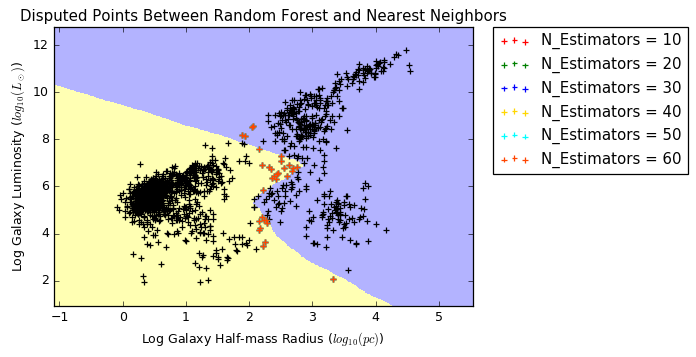

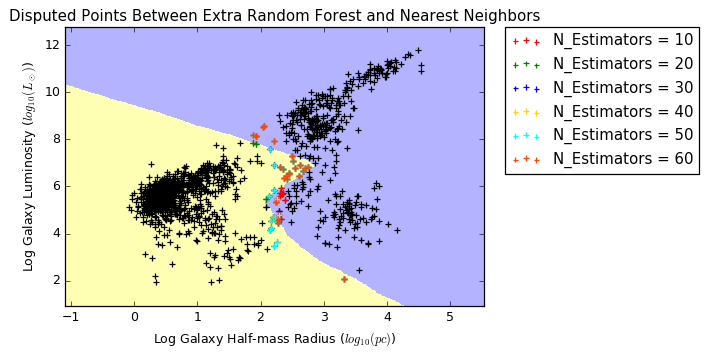

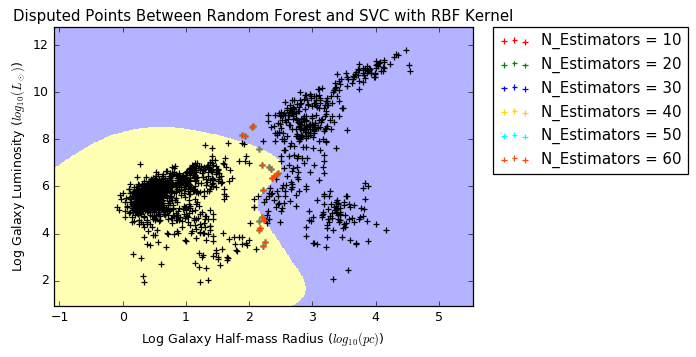

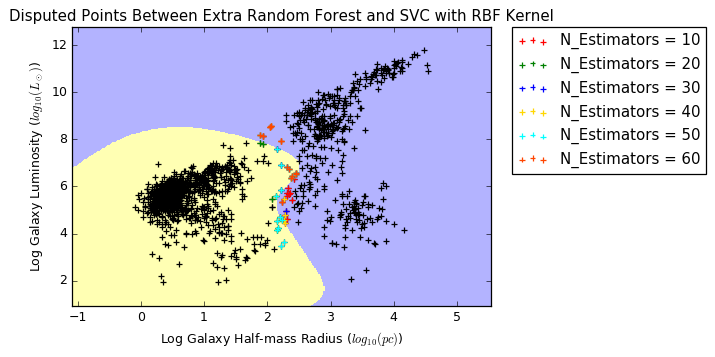

In [9]:

#Compare Random Forest to Nearest Neighbors
RandNN_disputed = CompareManyRoutinesToOne(X, NN_Prediction, RandForestPredictions, False)
labels = ['N_Estimators = 10', 'N_Estimators = 20', 'N_Estimators = 30', 'N_Estimators = 40', 'N_Estimators = 50',
         'N_Estimators = 60']
colors = ['r', 'g', 'b', 'gold', 'cyan', 'orangered']

plt.pcolormesh(NN_Prediction_DecisionBoundary[0], NN_Prediction_DecisionBoundary[1], 
              NN_Prediction_DecisionBoundary[2], cmap = cmap_light)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.scatter(X[:,0], X[:,1], c = 'k', marker = '+')
for points, label, color in zip(RandNN_disputed, labels, colors):
    plt.scatter(points[:, 0], points[:, 1], color = color, label = label, marker = '+')
plt.title('Disputed Points Between Random Forest and Nearest Neighbors')
plt.xlabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
plt.ylabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#Compare Extra Random Forest to Nearest Neighbors
ExtraNN_disputed = CompareManyRoutinesToOne(X, NN_Prediction, ExtraRandForestPredictions, False)
labels = ['N_Estimators = 10', 'N_Estimators = 20', 'N_Estimators = 30', 'N_Estimators = 40', 'N_Estimators = 50',
         'N_Estimators = 60']
colors = ['r', 'g', 'b', 'gold', 'cyan', 'orangered']

plt.pcolormesh(NN_Prediction_DecisionBoundary[0], NN_Prediction_DecisionBoundary[1], 
              NN_Prediction_DecisionBoundary[2], cmap = cmap_light)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.scatter(X[:,0], X[:,1], c = 'k', marker = '+')
for points, label, color in zip(ExtraNN_disputed, labels, colors):
    plt.scatter(points[:, 0], points[:, 1], color = color, label = label, marker = '+')
plt.title('Disputed Points Between Extra Random Forest and Nearest Neighbors')
plt.xlabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
plt.ylabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#Compare Random Forest to SVC with RBF kernel

RandRBF_disputed = CompareManyRoutinesToOne(X, SVC_RBF_Predictions, RandForestPredictions, False)
labels = ['N_Estimators = 10', 'N_Estimators = 20', 'N_Estimators = 30', 'N_Estimators = 40', 'N_Estimators = 50',
         'N_Estimators = 60']
colors = ['r', 'g', 'b', 'gold', 'cyan', 'orangered']

plt.pcolormesh(SVC_RBF_Decision_Boundary[0], SVC_RBF_Decision_Boundary[1], 
              SVC_RBF_Decision_Boundary[2], cmap = cmap_light)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.scatter(X[:,0], X[:,1], c = 'k', marker = '+')
for points, label, color in zip(RandRBF_disputed, labels, colors):
    plt.scatter(points[:, 0], points[:, 1], color = color, label = label, marker = '+')
plt.title('Disputed Points Between Random Forest and SVC with RBF Kernel')
plt.xlabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
plt.ylabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#Compare Extra Random Forest to SVC with RBF kernel

ExtraRBF_disputed = CompareManyRoutinesToOne(X, SVC_RBF_Predictions, ExtraRandForestPredictions, False)
labels = ['N_Estimators = 10', 'N_Estimators = 20', 'N_Estimators = 30', 'N_Estimators = 40', 'N_Estimators = 50',
         'N_Estimators = 60']
colors = ['r', 'g', 'b', 'gold', 'cyan', 'orangered']

plt.pcolormesh(SVC_RBF_Decision_Boundary[0], SVC_RBF_Decision_Boundary[1], 
              SVC_RBF_Decision_Boundary[2], cmap = cmap_light)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.scatter(X[:,0], X[:,1], c = 'k', marker = '+')
for points, label, color in zip(ExtraRBF_disputed, labels, colors):
    plt.scatter(points[:, 0], points[:, 1], color = color, label = label, marker = '+')
plt.title('Disputed Points Between Extra Random Forest and SVC with RBF Kernel')
plt.xlabel('Log Galaxy Half-mass Radius ($log_{10}(pc)$)')
plt.ylabel('Log Galaxy Luminosity ($log_{10}(L_\odot)$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Evidently, the discrepancies between Extra Random Forest and both Nearest Neighbors and the SVC with RBF kernel decrease as the number of estimators in the forest increase, clustering themselves more around the decision boundaries.

Generally, all the methods tended to make similar classifications, with much of the difference being in how the methods were able to construct boundary lines between the groups. Both Nearest Neighbors and SVC-RBF were able to capture an S-shaped curve in the middle of the data, which the Extra Random Forest also seemed to be approaching; in contrast, the linear SVCs and regular Random Forest were only able to create straight lines as boundaries. Nearest Neighbors showed the least variation as parameters changed, while SVC changed drastically depending on the kernel used. 